In [17]:
from sympy import *
import math
from matplotlib.mlab import griddata
from mpl_toolkits.mplot3d import Axes3D
import pylab as plt
from matplotlib import cm
import numpy as np

In [18]:
init_printing(use_latex="mathjax")

In [19]:
expr

<module 'sympy.core.expr' from '/opt/intel/intelpython2/lib/python2.7/site-packages/sympy/core/expr.pyc'>

In [20]:
E_value = 1
v_value = 0.25
dx_value = 100
dy_value = 100
dz_value = 10000

## Symbols

In [21]:
x, y = symbols("x y")

In [22]:
dx, dy= symbols("dx dy")

## Funções de Forma

In [23]:
N1 = (1-x/dx)*(1-y/dy)
N2 = (1-x/dx)*(0+y/dy)
N3 = (0+x/dx)*(0+y/dy)
N4 = (0+x/dx)*(1-y/dy)

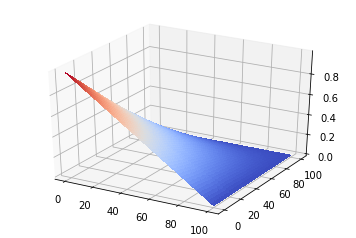

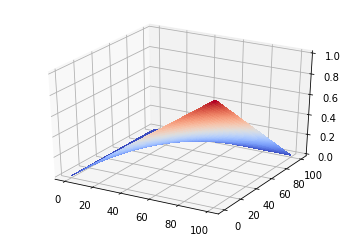

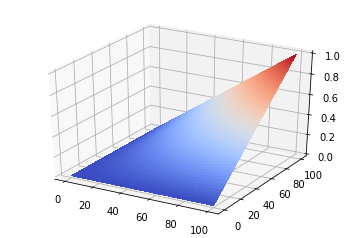

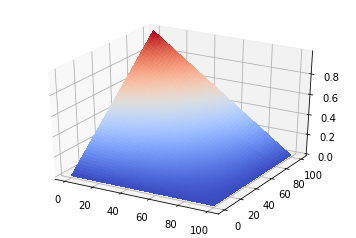

In [24]:
for N in [N1, N2, N3, N4]:

    X = np.linspace(0, dx_value)
    Y = np.linspace(0, dy_value)
    n = len(X)
    Z = np.zeros(n*n)


    
    i = 0
    for xx in X:
        for yy in Y:
            Z[i] = N.doit().subs(x, xx).subs(y, yy).subs(dx, dx_value).subs(dy, dy_value)
            i += 1

    X, Y = np.meshgrid(X, Y)

    Z = np.reshape(Z, (n, n))


    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    plt.show()


## Matriz de Elasticidade

In [25]:
E, v = symbols("E v")
Dinv = (1/E)*Matrix([[1,-v,0], [-v,1,0], [0, 0,2*(1+v)]])
D = simplify(Dinv**-1)

In [26]:
D

⎡ -E     -E⋅v             ⎤
⎢──────  ──────      0    ⎥
⎢ 2       2               ⎥
⎢v  - 1  v  - 1           ⎥
⎢                         ⎥
⎢-E⋅v     -E              ⎥
⎢──────  ──────      0    ⎥
⎢ 2       2               ⎥
⎢v  - 1  v  - 1           ⎥
⎢                         ⎥
⎢                    E    ⎥
⎢  0       0     ─────────⎥
⎣                2⋅(v + 1)⎦

In [27]:
A = Matrix([[1,2],[3,4],[5,6]])
A.shape


(3, 2)

In [28]:
def applyS(N):

    ddx = diff(N, x)
    ddy = diff(N, y)
    
    return Matrix([[ddx, 0], [0, ddy],  [ddy, ddx]])

In [29]:
applyS(N1)

⎡ ⎛    y ⎞             ⎤
⎢-⎜1 - ──⎟             ⎥
⎢ ⎝    dy⎠             ⎥
⎢──────────      0     ⎥
⎢    dx                ⎥
⎢                      ⎥
⎢             ⎛    x ⎞ ⎥
⎢            -⎜1 - ──⎟ ⎥
⎢             ⎝    dx⎠ ⎥
⎢    0       ──────────⎥
⎢                dy    ⎥
⎢                      ⎥
⎢ ⎛    x ⎞    ⎛    y ⎞ ⎥
⎢-⎜1 - ──⎟   -⎜1 - ──⎟ ⎥
⎢ ⎝    dx⎠    ⎝    dy⎠ ⎥
⎢──────────  ──────────⎥
⎣    dy          dx    ⎦

In [30]:
Stiff = applyS(N1).T*D*applyS(N2)
Aux = zeros(2,2)
for i in range(Stiff.shape[0]*Stiff.shape[1]):
    Aux[i] = Integral(Stiff[i],(x, 0, dx))
    Aux[i] = Integral(Aux[i],(y, 0, dy))
Stiff = Aux
Stiff

⎡   dy dx                                                                     
⎢   ⌠  ⌠                                                dy dx                 
⎢   ⎮  ⎮  ⎛             2                   ⎞           ⌠  ⌠                  
⎢   ⎮  ⎮  ⎜     ⎛    x ⎞           ⎛    y ⎞ ⎟           ⎮  ⎮  ⎛    ⎛    x ⎞ ⎛ 
⎢   ⎮  ⎮  ⎜   E⋅⎜1 - ──⎟       E⋅y⋅⎜1 - ──⎟ ⎟           ⎮  ⎮  ⎜E⋅v⋅⎜1 - ──⎟⋅⎜1
⎢   ⎮  ⎮  ⎜     ⎝    dx⎠           ⎝    dy⎠ ⎟           ⎮  ⎮  ⎜    ⎝    dx⎠ ⎝ 
⎢   ⎮  ⎮  ⎜- ───────────── - ───────────────⎟ dx dy     ⎮  ⎮  ⎜───────────────
⎢   ⎮  ⎮  ⎜      2             2    ⎛ 2    ⎞⎟           ⎮  ⎮  ⎜          ⎛ 2  
⎢   ⎮  ⎮  ⎝  2⋅dy ⋅(v + 1)   dx ⋅dy⋅⎝v  - 1⎠⎠           ⎮  ⎮  ⎝    dx⋅dy⋅⎝v  -
⎢   ⌡  ⌡                                                ⌡  ⌡                  
⎢   0  0                                                0  0                  
⎢                                                                             
⎢                                                   

In [31]:
def CalcConnectionAnalitic(N1, N2):
    Stiff = applyS(N1).T*D*applyS(N2)
    
    Aux = zeros(Stiff.shape[0], Stiff.shape[1])
    
    for i in range(Stiff.shape[0]*Stiff.shape[1]):
        Aux[i] = Integral(Stiff[i],(x, 0, dx))
        Aux[i] = Integral(Aux[i],(y, 0, dy))
        Aux[i] = simplify(Aux[i])

    Stiff = Aux
   
    return Stiff     

In [32]:
CalcConnectionAnalitic(N1, N2)

⎡dy dx                                                         dy dx          
⎢⌠  ⌠                                                          ⌠  ⌠           
⎢⎮  ⎮    ⎛                                2 ⎛   2    ⎞⎞        ⎮  ⎮           
⎢⎮  ⎮  E⋅⎝-2⋅y⋅(dy - y)⋅(v + 1) + (dx - x) ⋅⎝- v  + 1⎠⎠        ⎮  ⎮  E⋅(dx - x
⎢⎮  ⎮  ──────────────────────────────────────────────── dx dy  ⎮  ⎮  ─────────
⎢⎮  ⎮                 2   2         ⎛ 2    ⎞                   ⎮  ⎮           
⎢⎮  ⎮             2⋅dx ⋅dy ⋅(v + 1)⋅⎝v  - 1⎠                   ⎮  ⎮           
⎢⌡  ⌡                                                          ⌡  ⌡           
⎢0  0                                                          0  0           
⎢                                                                             
⎢dy dx                                                         dy dx          
⎢⌠  ⌠                                                          ⌠  ⌠           
⎢⎮  ⎮              ⎛                         ⎛ 2    

In [33]:
def CalcConnection(N1, N2):
    Stiff = applyS(N1).T*D*applyS(N2)
    
    Aux = zeros(Stiff.shape[0], Stiff.shape[1])
    
    for i in range(Stiff.shape[0]*Stiff.shape[1]):
        Aux[i] = Integral(Stiff[i],(x, 0, dx))
        Aux[i] = Integral(Aux[i],(y, 0, dy))
        Aux[i] = Integral(Aux[i],(z, 0, dz))
    
    Stiff = Aux
   
    for i in range(Stiff.shape[0]*Stiff.shape[1]):
        Aux[i]=Stiff[i].doit().subs(E, E_value).subs(v, v_value).subs(dx, dx_value).subs(dy, dy_value).subs(dz, dz_value)

    Stiff = Aux
    return Stiff  

In [34]:
ElementMatrix = Matrix([[CalcConnectionAnalitic(N1,N1), CalcConnectionAnalitic(N1,N2)]])

ElementMatrix

⎡⎡dy dx                                                                       
⎢⎢⌠  ⌠                                                             dy dx      
⎢⎢⎮  ⎮    ⎛        2 ⎛ 2    ⎞             2        ⎞               ⌠  ⌠       
⎢⎢⎮  ⎮  E⋅⎝(dx - x) ⋅⎝v  - 1⎠ - 2⋅(dy - y) ⋅(v + 1)⎠               ⎮  ⎮  -E⋅(d
⎢⎢⎮  ⎮  ──────────────────────────────────────────── dx dy         ⎮  ⎮  ─────
⎢⎢⎮  ⎮               2   2         ⎛ 2    ⎞                        ⎮  ⎮       
⎢⎢⎮  ⎮           2⋅dx ⋅dy ⋅(v + 1)⋅⎝v  - 1⎠                        ⎮  ⎮       
⎢⎢⌡  ⌡                                                             ⌡  ⌡       
⎢⎢0  0                                                             0  0       
⎢⎢                                                                            
⎢⎢                                                          dy dx             
⎢⎢      dy dx                                               ⌠  ⌠              
⎢⎢      ⌠  ⌠                                        

In [35]:
def evaluate(M):
    return M.doit().subs(E, E_value).subs(v, v_value).subs(dx, dx_value).subs(dy, dy_value)

In [36]:
Ns = [N1, N2, N3, N4]

def build_line(i):
    M = CalcConnectionAnalitic(Ns[i], Ns[0])
    
    for j in range(1, 4):
        M = M.col_insert(j, CalcConnectionAnalitic(Ns[i], Ns[j]))
        
    return M

M = build_line(0)

for i in range(1, 4):
    M = M.row_insert(i, build_line(i))
M

⎡  dy dx                                                       dy dx          
⎢  ⌠  ⌠                                                        ⌠  ⌠           
⎢  ⎮  ⎮    ⎛        2 ⎛ 2    ⎞             2        ⎞          ⎮  ⎮    ⎛      
⎢  ⎮  ⎮  E⋅⎝(dx - x) ⋅⎝v  - 1⎠ - 2⋅(dy - y) ⋅(v + 1)⎠          ⎮  ⎮  E⋅⎝-2⋅y⋅(
⎢  ⎮  ⎮  ──────────────────────────────────────────── dx dy    ⎮  ⎮  ─────────
⎢  ⎮  ⎮               2   2         ⎛ 2    ⎞                   ⎮  ⎮           
⎢  ⎮  ⎮           2⋅dx ⋅dy ⋅(v + 1)⋅⎝v  - 1⎠                   ⎮  ⎮           
⎢  ⌡  ⌡                                                        ⌡  ⌡           
⎢  0  0                                                        0  0           
⎢                                                                             
⎢dy dx                                                              dy dx     
⎢⌠  ⌠                                                               ⌠  ⌠      
⎢⎮  ⎮    ⎛                                2 ⎛   2   

In [37]:
evaluate(M)

⎡ 0.488888888888889   0.0444444444444444   -0.244444444444444   -0.28888888888
⎢                                                                             
⎢0.0444444444444444    0.488888888888889   -0.288888888888889   -0.24444444444
⎢                                                                             
⎢-0.244444444444444   -0.288888888888889    0.488888888888889   0.044444444444
⎢                                                                             
⎢-0.288888888888889   -0.244444444444444   0.0444444444444444    0.48888888888
⎢                                                                             
⎢-0.0333333333333333   0.166666666666667   0.0333333333333334   -0.16666666666
⎢                                                                             
⎢-0.166666666666667   0.0333333333333333    0.166666666666667   -0.03333333333
⎢                                                                             
⎢0.0333333333333333   -0.166666666666667   -0.033333

In [42]:
from Element import *

elem = Quadrilateral(0, E=E_value, v=v_value, elasticidade=True, ndim=2)

elem.AddNode(Node(0, 0.0, 0.0))
elem.AddNode(Node(1, 0.0, dy_value))
elem.AddNode(Node(2, dx_value, dy_value))
elem.AddNode(Node(3, dx_value, 0.0))


print elem.CalcKlocal()

[[ 0.48888889  0.16666667  0.04444444  0.03333333 -0.24444444 -0.16666667
  -0.28888889 -0.03333333]
 [ 0.16666667  0.48888889 -0.03333333 -0.28888889 -0.16666667 -0.24444444
   0.03333333  0.04444444]
 [ 0.04444444 -0.03333333  0.48888889 -0.16666667 -0.28888889  0.03333333
  -0.24444444  0.16666667]
 [ 0.03333333 -0.28888889 -0.16666667  0.48888889 -0.03333333  0.04444444
   0.16666667 -0.24444444]
 [-0.24444444 -0.16666667 -0.28888889 -0.03333333  0.48888889  0.16666667
   0.04444444  0.03333333]
 [-0.16666667 -0.24444444  0.03333333  0.04444444  0.16666667  0.48888889
  -0.03333333 -0.28888889]
 [-0.28888889  0.03333333 -0.24444444  0.16666667  0.04444444 -0.03333333
   0.48888889 -0.16666667]
 [-0.03333333  0.04444444  0.16666667 -0.24444444  0.03333333 -0.28888889
  -0.16666667  0.48888889]]


In [39]:
elem.Hooke()

array([[ 1.06666667,  0.26666667,  0.        ],
       [ 0.26666667,  1.06666667,  0.        ],
       [ 0.        ,  0.        ,  0.4       ]])

In [40]:
D.doit().subs(E, E_value).subs(v, v_value)

⎡1.06666666666667   0.266666666666667   0 ⎤
⎢                                         ⎥
⎢0.266666666666667  1.06666666666667    0 ⎥
⎢                                         ⎥
⎣        0                  0          0.4⎦